In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs

import sys
sys.path.insert(0, '/glade/u/home/zarzycki/sw/great_circle_calculator')
from gc_funcs.gc_functions import *

# module load conda
# conda activate npl-2023b

# Set the directory
dir_path = "/glade/derecho/scratch/stepheba/archive/"

# List of cases
#cases = ["b1850.054.f_outofbox"]
cases = [ "flthist134_outofbox", "flthist134.000f_ztest2", "b1850.054.f_outofbox", "b1850.054.f_ztest2"]
labels = [ "F_Lscale","F_taus","B_Lscale","B_taus" ]
colors = ['blue', 'red', 'blue', 'red']
dashes = [(1, 0), (1, 0), (1, 1), (1, 1)]  # Dash patterns: (line, space).

var = "Skw2"

# Initialize storage for the mean values
mean_store = None

for case in cases:
    print(f"{dir_path}/{case}")

    # Reading the files using xarray
    fils = f"{dir_path}/{case}/atm/hist/*h0*.nc"
    ds = xr.open_mfdataset(fils, combine='by_coords', parallel=True)

    # Extracting the variable
    if var == "Skw":
        myvar = ds['wp3']/(ds['wp2']**1.5)
    elif var == "Skw2":
        myvar = ds['Skw_velocity'] / ds['wp2']**0.5
    else:
        myvar = ds[var]
    print(myvar)

    # Storing lat, lon, and lev from the first case
    if mean_store is None:
        lat = ds['lat']
        lon = ds['lon']
        lev = ds['lev']
        nlat = lat.size
        nlon = lon.size
        nlev = lev.size
        var_units = myvar.attrs.get('units', 'No units found')

        # Check if 'lev' is a dimension in myvar
        do_levs = 'lev' in myvar.dims or 'ilev' in myvar.dims
        if do_levs:
            mean_store = np.zeros((len(cases), nlev, nlat, nlon))
        else:
            mean_store = np.zeros((len(cases), nlat, nlon))
        print(f"Does 'myvar' have a 'lev' dimension? {do_levs}")

    if do_levs:
        mean_store[cases.index(case), :, :, :] = myvar[:,0:nlev,:,:].mean(dim='time').values
    else:
        mean_store[cases.index(case), :, :] = myvar[:,:,:].mean(dim='time').values

# Get transect stuff
leftlat, leftlon = 20.0, 195.0-360.0
rightlat, rightlon = 30.0, 235.0-360.0
npts = 60

distance, gclats, gclons = gc_latlon(leftlat, leftlon, rightlat, rightlon, npts, 2)

target_points = np.array([gclats, gclons]).T

src_lats, src_lons = np.meshgrid(lat, lon, indexing='ij')
src_lons = src_lons - 360.0
src_points = np.array([src_lats.flatten(), src_lons.flatten()]).T


if do_levs:
    merge_trans = np.zeros((len(cases), nlev, npts))
else:
    merge_trans = np.zeros((len(cases), npts))


# Further processing and plotting
for ii in range(len(cases)):

    print(f"Interpolating case number {ii}")

    if do_levs:

        if ii == 0:
            merge_trans = np.zeros((len(cases), nlev, npts))
            interpolated_values_all_levels = np.empty((nlev, npts))

        for level in range(nlev):
                print(f"Interpolating level: {level}")
                src_values = mean_store[ii, level, :, :].flatten()
                interpolated_values = griddata(src_points, src_values, target_points, method='nearest')
                interpolated_values_all_levels[level, :] = interpolated_values

        merge_trans[ii, :, :] = interpolated_values_all_levels

    else:

        if ii == 0:
            merge_trans = np.zeros((len(cases), npts))

        src_values = mean_store[ii,:,:].flatten()
        interpolated_values = griddata(src_points, src_values, target_points, method='linear')

        merge_trans[ii, :] = interpolated_values

/glade/derecho/scratch/stepheba/archive//flthist134_outofbox
<xarray.DataArray (time: 60, ilev: 59, lat: 192, lon: 288)>
dask.array<truediv, shape=(60, 59, 192, 288), dtype=float32, chunksize=(1, 59, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.3 357.5 358.8
  * ilev     (ilev) float64 2.055 3.98 6.909 11.27 ... 979.0 987.4 995.1 1e+03
  * time     (time) object 1979-02-01 00:00:00 ... 1984-01-01 00:00:00
Does 'myvar' have a 'lev' dimension? True


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


/glade/derecho/scratch/stepheba/archive//flthist134.000f_ztest2
<xarray.DataArray (time: 72, ilev: 59, lat: 192, lon: 288)>
dask.array<truediv, shape=(72, 59, 192, 288), dtype=float32, chunksize=(1, 59, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.3 357.5 358.8
  * ilev     (ilev) float64 2.055 3.98 6.909 11.27 ... 979.0 987.4 995.1 1e+03
  * time     (time) object 1979-02-01 00:00:00 ... 1985-01-01 00:00:00


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


/glade/derecho/scratch/stepheba/archive//b1850.054.f_outofbox
<xarray.DataArray (time: 72, ilev: 59, lat: 192, lon: 288)>
dask.array<truediv, shape=(72, 59, 192, 288), dtype=float32, chunksize=(1, 59, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.3 357.5 358.8
  * ilev     (ilev) float64 2.055 3.98 6.909 11.27 ... 979.0 987.4 995.1 1e+03
  * time     (time) object 0001-02-01 00:00:00 ... 0007-01-01 00:00:00


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


/glade/derecho/scratch/stepheba/archive//b1850.054.f_ztest2
<xarray.DataArray (time: 72, ilev: 59, lat: 192, lon: 288)>
dask.array<truediv, shape=(72, 59, 192, 288), dtype=float32, chunksize=(1, 59, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.3 357.5 358.8
  * ilev     (ilev) float64 2.055 3.98 6.909 11.27 ... 979.0 987.4 995.1 1e+03
  * time     (time) object 0001-02-01 00:00:00 ... 0007-01-01 00:00:00


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


Interpolating case number 0
Interpolating level: 0
Interpolating level: 1
Interpolating level: 2
Interpolating level: 3
Interpolating level: 4
Interpolating level: 5
Interpolating level: 6
Interpolating level: 7
Interpolating level: 8
Interpolating level: 9
Interpolating level: 10
Interpolating level: 11
Interpolating level: 12
Interpolating level: 13
Interpolating level: 14
Interpolating level: 15
Interpolating level: 16
Interpolating level: 17
Interpolating level: 18
Interpolating level: 19
Interpolating level: 20
Interpolating level: 21
Interpolating level: 22
Interpolating level: 23
Interpolating level: 24
Interpolating level: 25
Interpolating level: 26
Interpolating level: 27
Interpolating level: 28
Interpolating level: 29
Interpolating level: 30
Interpolating level: 31
Interpolating level: 32
Interpolating level: 33
Interpolating level: 34
Interpolating level: 35
Interpolating level: 36
Interpolating level: 37
Interpolating level: 38
Interpolating level: 39
Interpolating level: 4

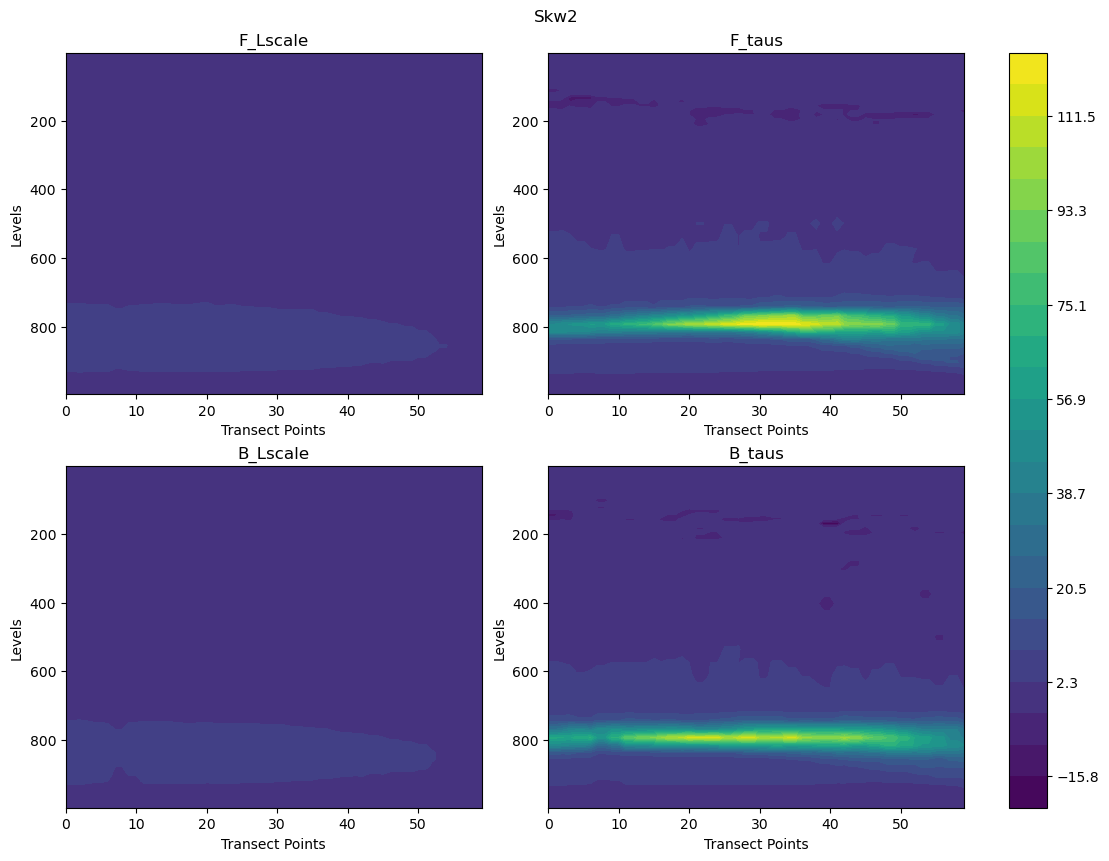

In [12]:
default_min, default_max = -1, 1
vmin_vmax_mapping = {
    "CLOUD": (0, 0.30),
    "T": (190, 310),
    "Skw": (-1, 1),
    "wp3": (0, 0.12),
}

if do_levs:

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(11, 8.5), layout='compressed')

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Get vmin and vmax from the dictionary
    #vmin, vmax = vmin_vmax_mapping.get(var, (default_min, default_max))
    vmin = np.min(merge_trans)
    vmax = np.max(merge_trans)
    
    # Plotting each cross-section for each case
    for i in range(4):
        ax = axs[i]
        case_data = merge_trans[i, :, :]  # Data for the current case
        X, Y = np.meshgrid(range(npts), lev)  # Create meshgrid for X (transect points) and Y (levels)

        # Choose the contour levels (if needed, based on your data range)
        contour_levels = np.linspace(vmin, vmax, num=25)

        # Plot the cross-section using contourf (could also use pcolormesh)
        ctf = ax.contourf(X, Y, case_data, levels=contour_levels, cmap='viridis')

        # Set the labels and titles
        ax.set_title(labels[i])
        ax.set_xlabel('Transect Points')
        ax.set_ylabel('Levels')

        ax.invert_yaxis()

    fig.suptitle(var)

    # Draw the colorbar
    fig.colorbar(ctf, ax=axs[1:3], orientation='vertical')

    
    # Show the plot
    plt.show()

else:
    points = np.linspace(0, npts-1, npts)
    plt.figure()
    for i in range(merge_trans.shape[0]):
        line, = plt.plot(points, merge_trans[i, :], label=labels[i], color=colors[i])
        line.set_dashes(dashes[i])  # Set the dash pattern

    plt.xlabel('Points')
    plt.ylabel(var + " (" + var_units + ")")
    plt.legend()

    plt.xlim(0, 100)

    plt.show()